In [1]:
import pandas as pd 
import hashlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)
import numpy as np

In [2]:
features_df = pd.read_csv("power_consumption_g1_feat.csv")
features_df

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900
...,...,...,...,...,...,...
52411,2017-05-14 02:20:00,23.58,43.10,0.075,0.110,0.122
52412,2017-11-17 19:20:00,17.30,76.50,0.075,0.040,0.148
52413,2017-03-21 12:10:00,17.90,50.28,0.081,837.000,296.700
52414,2017-07-28 05:10:00,25.23,61.32,4.907,0.091,0.119


In [3]:
features_df["Datetime"] = pd.to_datetime(features_df["Datetime"])
features_df.set_index(keys=["Datetime"], inplace=True)
features_df.sort_index(inplace=True)
features_df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Datetime,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085
...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,NaN,0.096
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074


In [4]:
target_df = pd.read_csv("power_consumption_g1.csv")

In [5]:
target_df["Datetime"] = pd.to_datetime(target_df["Datetime"])
target_df.set_index(keys=["Datetime"], inplace=True)
target_df.sort_index(inplace=True)
target_df

,PowerConsumption
Datetime,
2017-01-01 00:00:00,34055.69620
2017-01-01 00:10:00,29814.68354
2017-01-01 00:20:00,29128.10127
2017-01-01 00:30:00,28228.86076
2017-01-01 00:40:00,27335.69620
...,...
2017-12-30 23:10:00,31160.45627
2017-12-30 23:20:00,30430.41825
2017-12-30 23:30:00,29590.87452


In [6]:
df = pd.merge(left=features_df, right=target_df, right_index=True, left_index=True)
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620
...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,NaN,0.096,31160.45627
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452


In [7]:
df.isnull().sum()

Temperature            559
Humidity               499
WindSpeed              529
GeneralDiffuseFlows    524
DiffuseFlows           505
PowerConsumption         0
dtype: int64

In [8]:
features = ["Temperature", "Humidity", "WindSpeed", "GeneralDiffuseFlows", "DiffuseFlows"]
target = "PowerConsumption"

In [9]:
for feature in features:
    df[feature] = df[feature].interpolate(method="linear")

In [10]:
df = df.groupby(pd.Grouper(freq="30min")).mean()
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00:00,6.428667,74.266667,0.082000,0.061000,0.101333,30999.493670
2017-01-01 00:30:00,5.941000,75.866667,0.081667,0.066000,0.096333,27396.455697
2017-01-01 01:00:00,5.605000,77.900000,0.082000,0.056333,0.110000,25407.594937
2017-01-01 01:30:00,5.492667,77.166667,0.082000,0.057333,0.115000,23906.835443
2017-01-01 02:00:00,5.000667,78.766667,0.082667,0.065000,0.127333,22474.936707
...,...,...,...,...,...,...
2017-12-30 21:30:00,7.913333,70.343333,0.081667,0.069333,0.087667,34786.311787
2017-12-30 22:00:00,7.793333,69.563333,0.081000,0.062333,0.108667,34660.583017
2017-12-30 22:30:00,7.403333,71.066667,0.082667,0.055000,0.107667,33326.235743


<Axes: xlabel='Datetime', ylabel='Temperature'>

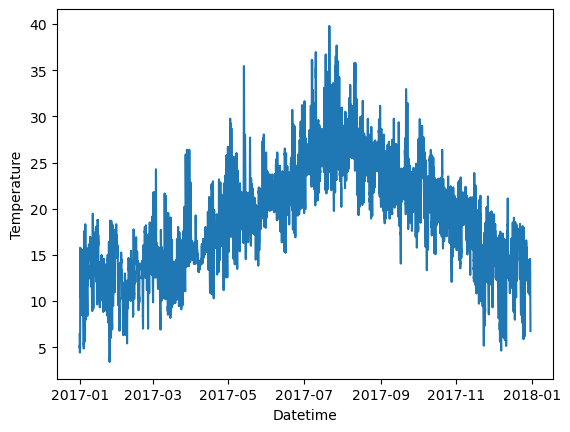

In [11]:
import seaborn as sns

sns.lineplot(df["Temperature"])

<Axes: xlabel='Datetime', ylabel='Humidity'>

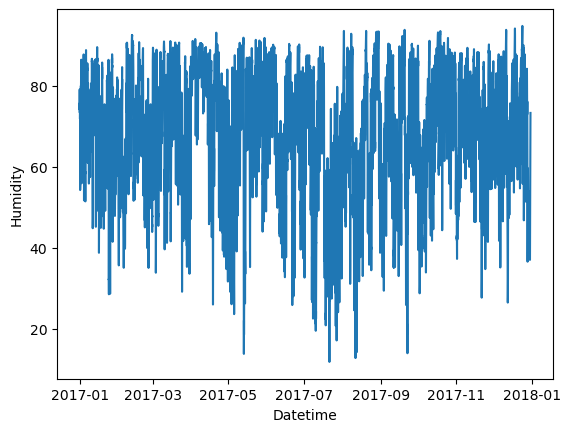

In [12]:
sns.lineplot(df["Humidity"])

<Axes: xlabel='Datetime', ylabel='WindSpeed'>

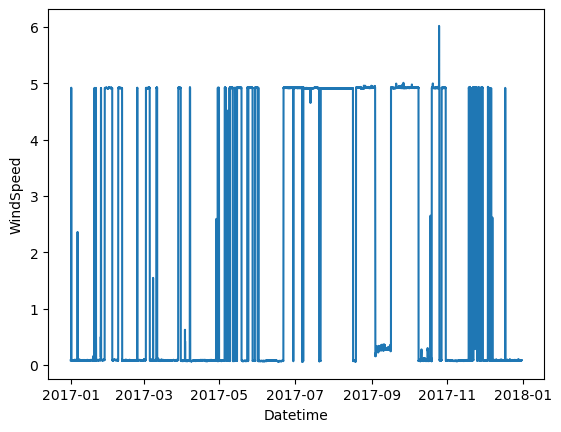

In [13]:
sns.lineplot(df["WindSpeed"])

<Axes: xlabel='Datetime', ylabel='GeneralDiffuseFlows'>

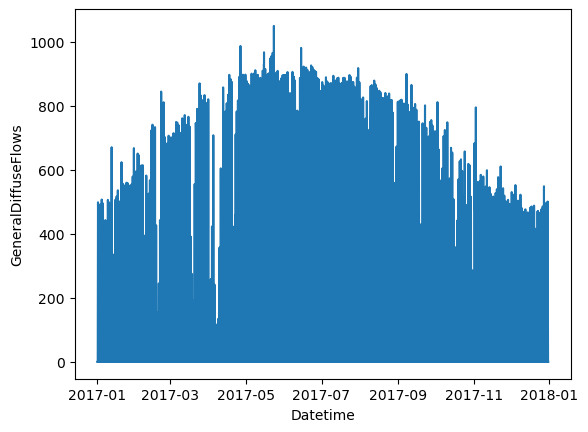

In [14]:
sns.lineplot(df["GeneralDiffuseFlows"])

<Axes: xlabel='Datetime', ylabel='DiffuseFlows'>

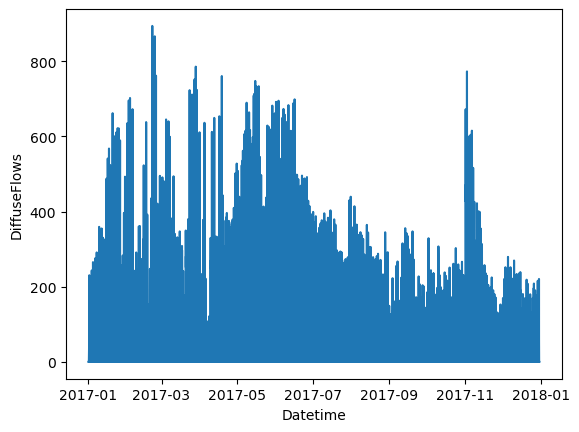

In [15]:
sns.lineplot(df["DiffuseFlows"])

In [16]:
lags = range(5,0,-1)
list(lags)

[5, 4, 3, 2, 1]

In [17]:
for lag in lags:
    for column in features + [target]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption,Temperature_5,Humidity_5,WindSpeed_5,GeneralDiffuseFlows_5,...,WindSpeed_2,GeneralDiffuseFlows_2,DiffuseFlows_2,PowerConsumption_2,Temperature_1,Humidity_1,WindSpeed_1,GeneralDiffuseFlows_1,DiffuseFlows_1,PowerConsumption_1
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.428667,74.266667,0.082000,0.061000,0.101333,30999.493670,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:30:00,5.941000,75.866667,0.081667,0.066000,0.096333,27396.455697,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.428667,74.266667,0.082000,0.061000,0.101333,30999.493670
2017-01-01 01:00:00,5.605000,77.900000,0.082000,0.056333,0.110000,25407.594937,NaN,NaN,NaN,NaN,...,0.082000,0.061000,0.101333,30999.493670,5.941000,75.866667,0.081667,0.066000,0.096333,27396.455697
2017-01-01 01:30:00,5.492667,77.166667,0.082000,0.057333,0.115000,23906.835443,NaN,NaN,NaN,NaN,...,0.081667,0.066000,0.096333,27396.455697,5.605000,77.900000,0.082000,0.056333,0.110000,25407.594937
2017-01-01 02:00:00,5.000667,78.766667,0.082667,0.065000,0.127333,22474.936707,NaN,NaN,NaN,NaN,...,0.082000,0.056333,0.110000,25407.594937,5.492667,77.166667,0.082000,0.057333,0.115000,23906.835443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 21:30:00,7.913333,70.343333,0.081667,0.069333,0.087667,34786.311787,9.710000,61.685000,0.075000,0.052667,...,0.086000,0.066000,0.090000,36846.641317,8.110000,69.006667,0.081333,0.077000,0.109000,35930.038023
2017-12-30 22:00:00,7.793333,69.563333,0.081000,0.062333,0.108667,34660.583017,9.196667,63.106667,0.074333,0.051333,...,0.081333,0.077000,0.109000,35930.038023,7.913333,70.343333,0.081667,0.069333,0.087667,34786.311787
2017-12-30 22:30:00,7.403333,71.066667,0.082667,0.055000,0.107667,33326.235743,8.933333,63.473333,0.074667,0.039333,...,0.081667,0.069333,0.087667,34786.311787,7.793333,69.563333,0.081000,0.062333,0.108667,34660.583017


In [18]:
df.drop(columns=features, inplace=True)

In [19]:
df.dropna(axis=0, inplace=True)

In [20]:
df

,PowerConsumption,Temperature_5,Humidity_5,WindSpeed_5,GeneralDiffuseFlows_5,DiffuseFlows_5,PowerConsumption_5,Temperature_4,Humidity_4,WindSpeed_4,...,WindSpeed_2,GeneralDiffuseFlows_2,DiffuseFlows_2,PowerConsumption_2,Temperature_1,Humidity_1,WindSpeed_1,GeneralDiffuseFlows_1,DiffuseFlows_1,PowerConsumption_1
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 02:30:00,21691.139240,6.428667,74.266667,0.082000,0.061000,0.101333,30999.493670,5.941000,75.866667,0.081667,...,0.082000,0.057333,0.115000,23906.835443,5.000667,78.766667,0.082667,0.065000,0.127333,22474.936707
2017-01-01 03:00:00,20992.405063,5.941000,75.866667,0.081667,0.066000,0.096333,27396.455697,5.605000,77.900000,0.082000,...,0.082667,0.065000,0.127333,22474.936707,5.108000,79.100000,0.082000,0.061000,0.131000,21691.139240
2017-01-01 03:30:00,20629.873417,5.605000,77.900000,0.082000,0.056333,0.110000,25407.594937,5.492667,77.166667,0.082000,...,0.082000,0.061000,0.131000,21691.139240,5.097000,77.600000,0.082667,0.059667,0.130000,20992.405063
2017-01-01 04:00:00,20512.405063,5.492667,77.166667,0.082000,0.057333,0.115000,23906.835443,5.000667,78.766667,0.082667,...,0.082667,0.059667,0.130000,20992.405063,4.911667,76.566667,0.083000,0.060000,0.152000,20629.873417
2017-01-01 04:30:00,20439.493670,5.000667,78.766667,0.082667,0.065000,0.127333,22474.936707,5.108000,79.100000,0.082000,...,0.083000,0.060000,0.152000,20629.873417,4.952333,74.733333,0.083667,0.058667,0.117333,20512.405063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 21:30:00,34786.311787,9.710000,61.685000,0.075000,0.052667,0.108667,37690.240813,9.196667,63.106667,0.074333,...,0.086000,0.066000,0.090000,36846.641317,8.110000,69.006667,0.081333,0.077000,0.109000,35930.038023
2017-12-30 22:00:00,34660.583017,9.196667,63.106667,0.074333,0.051333,0.095333,37337.389100,8.933333,63.473333,0.074667,...,0.081333,0.077000,0.109000,35930.038023,7.913333,70.343333,0.081667,0.069333,0.087667,34786.311787
2017-12-30 22:30:00,33326.235743,8.933333,63.473333,0.074667,0.039333,0.120000,37171.102660,9.150000,64.506667,0.086000,...,0.081667,0.069333,0.087667,34786.311787,7.793333,69.563333,0.081000,0.062333,0.108667,34660.583017


In [21]:
X, y = df.drop(columns=[target]), df[target]

In [22]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [24]:
scaler = MinMaxScaler()
train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))

In [25]:
train_X = train_X.reshape((train_X.shape[0], lag, (train_X.shape[1] // lag)))
test_X = test_X.reshape((test_X.shape[0], lag, (test_X.shape[1] // lag)))